## Data and code demonstrating the efficacy of databases relative to existing mass-spectrometry data formats

This repository pioneers the use of SQL databases for the efficient storage and access of raw
mass-spectrometry (MS) data. Here, "raw" MS data refers to the data encoded in vendor or .mzML files and contains
coordinates of retention time, *m/z* ratio, and intensity.

Existing data formats fail to provide intuitive, rapid, and programmatic search of raw MS data and require learning
the quirks and conceits of idiosyncratic file formats. Databases have
consistent and transferrable syntax for queries, indexing and binary search for rapid data extraction,
benefit from multi-file aggregations of data, can store processed data alongside, and are established as an industry standard.

Multiple efforts have revealed where SQL is acknowledged as an excellent solution for MS data, including

  1. Metabolomics Workbench
  2. MassQL development
  3. Spectra package backends

### Consistent and transferrable syntax

SQL is widely known and understood. Transforming MS data into a format that can be queried using SQL allows
developers to focus on building downstream products instead of comprehending the particulars of a given
file type. SQL also often results in queries much closer to natural language - compare 

```SELECT * FROM MS1 WHERE rt BETWEEN 5 AND 6```

to

```python
import matplotlib.pyplot as plt
from pyteomics import mzml
import numpy as np

mz_values = []
retention_times = []
int_values = []
with mzml.MzML(file) as reader:
    for spectrum in reader:
        if spectrum['ms level'] == 1:
            mz_values.extend(spectrum['m/z array'])
            mz_values.extend(spectrum['intensity array'])
            rt = spectrum['scanList']['scan'][0]['scan start time']
            retention_times.extend([rt] * len(spectrum['m/z array']))
```

### Indexing and binary search for rapid data extraction

Databases can be highly optimized for the extraction of data subsets. For MS data, this means that
it's just as easy to find a single scan as it is to extract an entire chromatogram. Many existing
data formats have indexes built in that identify the start or end byte of a given scan, but still
require every scan to be extracted when the information *within* the scan is of interest (as when
subsetting by *m/z* or intensity).

### Benefit from multi-file data aggregations

Existing MS data formats preserve the idea of "one sample = one file". With databases, the filename or
identifier can be simply encoded as an additional column and the entire dataset can be concatenated
together, allowing for rapid searches across every file simultaneously. Without this, MS datasets
increase linearly in time with the number of files in the dataset as each file is looped over
one at a time.

### Can store processed data alongside

After chromatographic peakpicking or compound identification has been performed, the resulting
peak list (start_rt, end_rt, mean_mz, area, etc.) can be stored as an additional table in the
database. Not only does this make it easy to share all the data (often a single .sql file or 
database connection instead of multiple mzMLs and CSVs), but it also allows for powerful
join operations between the raw and processed data that enable rapid extraction of the
individual data points that compose a chromatographic peak. Additionally, metadata or corrected
retention times similarly benefit from simple and powerful joins that minimize memory usage.

### Established as an industry standard

Databases are being actively developed by corporations much larger than any mass-spectrometry lab. This
means that the improvements in access speed and compression efficiency can be passed along to the MS
data within them without any extra effort. Additionally, databases are supported by an enormous community
of experts rather than individual developers who may leave the project and result in a deprecated file type.

## Goals

1. Determine when and how databases offer a performance improvement over existing MS file types
2. Explore multiple database types and provide use-case recommendations for each
3. Provide code that allows for the elegant conversion of existing MS data into database

## Existing formats for comparison:

| Format | Publication | Year | Interface | In msconvert? | m/z values searchable? | Written/examples in | Notes |
| --- | --- | --- | --- | --- | --- | --- | ---
| mzML | [Link](https://www.mcponline.org/article/S1535-9476(20)31387-6/fulltext) | 2010 | XML | Yes | No | Many | |
| mzRTree | [Link](https://dx.doi.org/10.1016/j.jprot.2010.02.006) | 2010 | Tree | No | ? | Java | |
| YAFMS | [Link](https://dx.doi.org/10.1016/j.jasms.2010.06.014) | 2010 | SQL | No | No | C# | Deprecated? |
| mz5 | [Link](https://dx.doi.org/10.1074/mcp.O111.011379) | 2012 | HDF5 | Yes | ? | ? | |
| mzDB | [Link](https://dx.doi.org/10.1074/mcp.O114.039115) | 2015 | SQL | No | Yes? | Java, C++ | |
| Indexed mzML | [Link](https://dx.doi.org/10.1371/journal.pone.0125108) | 2015 | XML | Yes | No | C++, Python | |
| MzTree | [Link](https://dx.doi.org/10.1371/journal.pone.0188059) | 2017 | SQLite, Tree | No | Yes? | Java | |
| Toffee | [Link](https://dx.doi.org/10.1038/s41598-020-65015-y) | 2020 | HDF5(?) | No | Yes? | Python | Only for TOF data? |
| mzMLb | [Link](https://dx.doi.org/10.1021/acs.jproteome.0c00192) | 2021 | XML | Yes | No | Python | |
| Aird | [Link](https://dx.doi.org/10.1186/s12859-021-04490-0) | 2022 | Unique | No | ? | C# | |
| mzMD | [Link](https://dx.doi.org/10.1093/bioinformatics/btac098) | 2022 | SQL | No | ? | Java | |
| MZA | [Link](https://dx.doi.org/10.1021/acs.jproteome.2c00313) | 2023 | HDF5 | No | Yes? | Python | Separate Python package [here](https://dx.doi.org/10.1021/acs.analchem.3c01653)

Not mentioned above: mzData, mzXML, Shaduf, imzML, others?

<details>

<summary>mzML</summary>

Lots of different ways to get data out of mzMLs, including 3 dedicated Python libraries I've discovered:

  - pyteomics
  - pymzml
  - pyopenms: Wrapper around a bunch of C code to do things
      - Has multiple methods of accessing mz/rt chunks

I can't seem to get the indexed version working, at least in such a way that speeds up spectrum access. It feels like something along the lines of the below code should work (for pyteomics), but returns strange errors. 

```python
file_data=mzml.PreIndexedMzML("demo_data/180205_Poo_TruePoo_Full1_idx.mzML")
file_data=file_data.build_byte_index()
```

I also can't tell if something similar is implemented in the other libraries. Also, it may be that the other libraries just handle indexing automagically.

</details>

<details>

<summary>mzMLb</summary>


Seems to only be implemented in pyteomics? Double check this later.

</details>

<details>

<summary>mzDB</summary>


Creation is pretty straightforward via the raw2mzDB.exe tool but we can't really figure out how to access the data. Package code exists (the original developers have a Python (and R) port of some Rust code but have responded saying that the [rt/mz range extraction isn't yet supported](https://github.com/mzdb/mzdb-rs/issues/3) and hasn't been [since Johannes asked about it in 2018?](https://github.com/mzdb/rmzdb/issues/3). Developer seems responsive but just overwhelmed. R-specific rmzdb package (not to be confused with the rmzdb port of the Rust code) hasn't been touched in 5 years, the Rust/Python/R hasn't been updated in one and a half.

Someone else [wrote a Python package for mzDB access](https://github.com/jerkos/pymzdb) (annoyingly, named the same as the dev Rust port) which has all the associated functions but it's 9 years old and I haven't gotten the chance to give it a try yet and the README is sparse.

Dev version of pymzdb: 8 commits total, 2 years ago

Other version of pymzdb: 10 commits total, 9 years ago

</details>

<details>

<summary>MzTree</summary>

In the sole Github issue that exists for this, the developer says "MZTree is not a format like, say, mzML or .raw. It is a storage and retrieval system." Frankly, I don't understand what this means - the data's gotta be stored somewhere and the article certainly makes it sound like it's a method for storing the data for rapid access. After following the instructions on the Github for installation and compilation with Apache Maven, I'm able to access msViz (`java -jar MZTree/msDataServer/msDataServer-1.0.jar`) and convert mzMLs to mzTree files (and the mzTree-points extra) but can't figure out how to query the server. Running `ifconfig` in WSL (where I installed msViz) gave me the IP address to use (172.27.178.175) which, combined with the port number specified in the application let me open a client with Chrome. I then tried to guess at the parameters but got a 500 internal server error with `http://172.27.178.175:4567/api/v2/getpoints?mzmin=118.08&mzmax=118.10&rtmin=0&rtmax=100`. Instead, I needed to specify numpoints as well so `http://172.27.178.175:4567/api/v2/getpoints?mzmin=118.08&mzmax=118.10&rtmin=0&rtmax=10&numpoints=0` returns the expected data.

8 commits in the repo, last one 7 years ago.

</details>

<details>

<summary>mzMD</summary>

Basically a port of MzTree with some upgrades to the visualization system, so results should be comparable. Their Github is just a pared-down version of MzTree's, no install or startup instructions but seems to behave exactly like MzTree. The MzViz API is exactly the same except the final parameter (number of points) has been changed to `n` and `m` parameters: `http://172.27.178.175:4567/api/v2/getpoints?mzmin=118.08&mzmax=118.10&rtmin=6.5&rtmax=8&n=0&m=0`.

3 commits in the repo (basically just "add files via upload"), last one 4 years ago.

</details>

<details>

<summary>mz5</summary>

Successfully created mz5 file via msconvert and wrote Python code for accessing mz5 files but it's pretty basic. Could maybe be sped up/accelerated with the [pymz5](https://github.com/jmchilton/pymz5/tree/master) library but that library is pretty old now and didn't seem to take off at all (zero issues, very few interactions). Doesn't provide any info about how to use the library either beyond install even though it seems like a ton of work was put into it (782 commits).
I still need to try this library and see whether it's functional but I'm skeptical - 11 years ago was still Python 2, right?

782 commits in the repo, last one 11 years ago

</details>

<details>

<summary>MZA</summary>

Files were created successfully via the command-line tool (although the README was only recently updated to tell the user how to download it from the releases). Installing `mzapy` from the `no_full_mz_array` branch worked after some back and forth with the responsive dev. Also wrote my own Python access code treating it as an HDF5 which surprisingly made RT range queries much faster, though the chromatogram extraction is faster with `mzapy`.

20 commits in the MZA repo, last one 2 days ago (after I opened an issue for it, prior to which it had been 2 years)

80 commits in the `mzapy` repo with more on various branches, last one a few days ago (after I opened an issue for it)

</details>

<details>

<summary>Aird</summary>

Haven't started yet. Lots of development, lots of support and interest. Seems to have built-in Python support, last updated 2 years ago. Unclear whether it's faster or just more compressed - they don't really show a speed vs format graph AFAIK. For whatever reason, Python isn't recognizing the install but I think that's on me. Conversion was successful and I've uploaded the .aird and .json files to demo_data.

466 commits in the repo, last one 7 months ago (2 years for the python-specific stuff)

</details>

<details>

<summary>Incomparables</summary>

### YAFMS

Seems fully deprecated - the link in the original manuscript now just redirects to PNNL's general software page and I can't find any residuals of the code via quick Googling.

### mzRTree

Haven't started yet. Seems like an older file type and only really compares to GUI formats. No idea how to convert the data into this format or access it - there's no Github I've been able to find and the only code associated I have found [is in Matlab](https://viewer.mathworks.com/?viewer=plain_code&url=https%3A%2F%2Fwww.mathworks.com%2Fmatlabcentral%2Fmlc-downloads%2Fdownloads%2Fe5af2033-4a80-11e4-9553-005056977bd0%2F65b8e141-bbf2-ecf1-80a0-1929890c734e%2Ffiles%2F3DSpectra%2FmzRTreeCreation.m&embed=web). mzDB somehow made it work (and found an example file?) but I have no idea how they did this.

### Toffee

Only works with TOF data, as far as I can tell. That disqualifies it from comparison in my opinion.

### UIMF

UIMF is used by PNNL for their large-scale MS data and uses SQLite as the backend but all the access code is written in C#/C++ and doesn't have a shallow enough learning curve for me to pick it up.

</details>

## Results

      method      time metric                    datetime
0  pyteomics  0.061288   spec  2024-11-21 10:30:09.568607
1  pyteomics  0.039154   spec  2024-11-21 10:30:09.568607
2  pyteomics  0.040040   spec  2024-11-21 10:30:09.568607
3  pyteomics  0.040864   spec  2024-11-21 10:30:09.568607
4  pyteomics  0.038373   spec  2024-11-21 10:30:09.568607


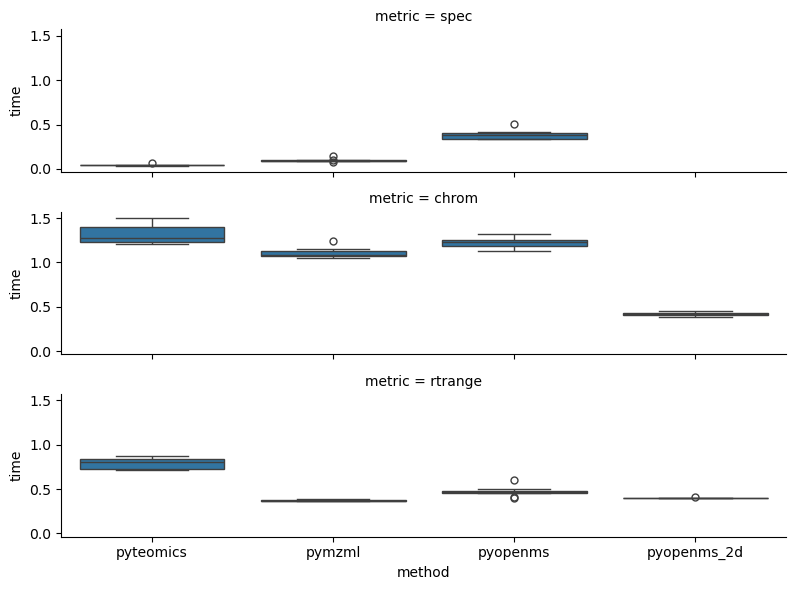

In [15]:
import pandas as pd
import seaborn

timing_data = pd.read_csv("demo_notebooks/compiled_timings.csv")

seaborn.catplot(
    data=timing_data, 
    x="method", 
    y="time", 
    row="metric", 
    kind="box", 
    height=2,
    aspect=4
)

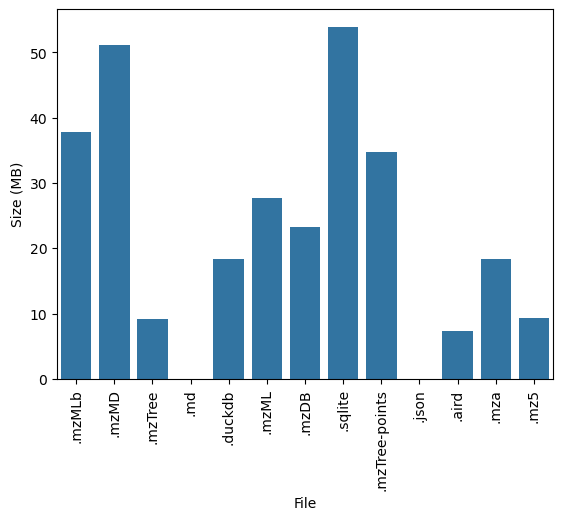

In [23]:
import os
import matplotlib.pyplot as plt

file_sizes = {os.path.splitext(file)[1]: os.path.getsize(os.path.join('demo_data', file)) 
              for file in os.listdir('demo_data') 
              if os.path.isfile(os.path.join('demo_data', file))}

# Create DataFrame
filesize_df = pd.DataFrame(list(file_sizes.items()), columns=['File', 'Size (MB)'])
filesize_df["Size (MB)"] = filesize_df["Size (MB)"]/1e6

# Plot barplot
sns.barplot(x='File', y='Size (MB)', data=filesize_df)
plt.xticks(rotation=90)  # Rotate file names if they are long
plt.show()

README.md compiled from README.ipynb. Use `jupyter nbconvert --to markdown README.ipynb` to recompile.